In [91]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed
import multiprocessing


import warnings
warnings.filterwarnings('ignore')


In [92]:
%matplotlib inline  

In [93]:
## Set user-defined variables
roll_width = 20
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow'
sBmp = 'bmps/%06d.bmp'
sFeatureVectors = 'feature_vectors/%06d.txt'
sSubPD = 'pd_sub/%06d.csv'
sSupPD = 'pd_sup/%06d.csv'

delta = 10

## Utility Functions

In [94]:
def loadData(_idx):
    
    # Get feature vectors
    _fv = pd.read_csv(sDir + "/" + (sFeatureVectors % idx), sep=' ', header=None)
    _fv = np.asarray(_fv.astype(np.int16))
    
    # Extract toplogical defects (a.k.a. singular points) from feature vectors
    offset = 5
    _td_p1 = _fv[(_fv[:,4+offset]==1),:]
    _td_p1 = np.hstack((_td_p1[:,[3,4]], np.ones((_td_p1.shape[0],1))))
    _td_m1 = _fv[(_fv[:,5+offset]==1),:]
    _td_m1 = np.hstack((_td_m1[:,[3,4]], np.ones((_td_m1.shape[0],1))*-1))
    _sp = pd.DataFrame(np.vstack((_td_p1, _td_m1)), columns=['col', 'row', 'type'])
    _sp = _sp.drop_duplicates()
    
    # Extract persistent homology pinch-off points from feature vectors
    _pinch = np.vstack((_fv[(_fv[:,0+offset]==1),:], _fv[(_fv[:,2+offset]==1),:]))
    _pinch = _pinch[:,[3,4]]
    _pinch = pd.DataFrame(_pinch, columns=['col', 'row'])
    _pinch = _pinch.drop_duplicates()
    
    # Get bitmap image
    _bmp = misc.imread(sDir + "/" + sBmp % idx)
    
    # Get H1 generators for spiral/target disambiguation
    _ph_features_sub = pd.read_csv(sDir + "/" + (sSubPD % idx))
    _ph_features_sub = pd.DataFrame(_ph_features_sub)
    
    _ph_dim1_sub = _ph_features_sub.loc[(_ph_features_sub['dim']==1) & ((_ph_features_sub['death'] - _ph_features_sub['birth']) >= delta) & (_ph_features_sub['birth']<=127)][['d_x','d_y']]
    
    _ph_features_sup = pd.read_csv(sDir + "/" + (sSupPD % idx))
    _ph_features_sup = pd.DataFrame(_ph_features_sup)
    
    _ph_dim1_sup = _ph_features_sup.loc[(_ph_features_sup['dim']==1) & ((_ph_features_sup['birth'] - _ph_features_sup['death']) >= delta) & (_ph_features_sup['birth']>=127)][['b_x','b_y']]
    
    _h1gens = np.vstack((_ph_dim1_sub, _ph_dim1_sup))
    _h1gens = pd.DataFrame(_h1gens, columns=['col', 'row'])
    
    return (_fv, _sp, _pinch, _bmp, _h1gens)


## The Code.

In [121]:

def classify_all_defects(bmp, td_classify, persistence_h1_gens, radius=10):
    """
    Locates and classifies canonical defects in a locally-striped pattern. 
    Canonical defects are:

    - Concave disclination (-1 charge monoid)
    - Convex disclination (+1 charge monoid)
    - Dislocation pair (+/-1 charge dipole)
    - Grain Boundary (alternating +/-1 sequence)
    - Target (two +1 charges with rules)
    - Spiral (two +1 charges with rules)

    Parameters:
    bmp = locally-striped pattern, ndarray bitmap
    td_classify = the topological defect array for classifying
    persistence_h1_gens = persistent homology h1 generator array for differentiating target/spiral
    radius = (10) the radius for clustering the nonzero-charged defects in td_classify

    Output:
    A list of defect regions, their type, and extra info about them. Types are:

    'disclination-concave'
    'disclination-convex'
    'dislocation pair'
    'grain boundary'
    'target'
    'spiral'

    Defect region is a binary matrix, attributes are a string of text containing extra info.

    """
    
    ## GET DEFECT CLUSTERS
    # Dilate nonzero topological defects by radius

    td_classify = td_classify.astype(np.int)
    td_clusters = (td_classify <> 0).astype(np.int)
    td_clusters = morphology.binary_dilation(td_clusters, morphology.disk(radius))

    ## IDENTIFY DEFECTS 
    # Make the master list of defects
    all_defects = []

    # Label the clusters and get the list of labels
    defect_components = measure.label(td_clusters, background=0)+1
    component_list = np.unique(defect_components)
    component_list = list(set(component_list))

    ## PROCESS DEFECT CLUSTERS
    
    # Parallel Processing
    num_cores = multiprocessing.cpu_count()   
    results = Parallel(n_jobs=num_cores)(delayed(classify_defect_cluster)(bmp, defect_components == component, td_classify, persistence_h1_gens, radius) \
                                         for component in component_list)
    for process_defects in results:
        for new_defect in process_defects:
            all_defects.append(new_defect)
            
#     # Sequential Processing
#     for component in component_list:
#         result = classify_defect_cluster(bmp, defect_components == component, td_classify, persistence_h1_gens, radius)
#         for defect in result:
#             all_defects.append(defect)
    
    return all_defects


def classify_defect_cluster(bmp, defect_region, td_points, persistence_h1_gens, radius):
    """
    Takes in a single defect cluster (and other info) and returns a list of classified defects (if any).
    """

    list_of_classified_defects = []
    
    # Convert topological defect array into a list
    td_points_list = np.asarray([ (i,j,td_points[i,j]) for (i,j) in np.argwhere(td_points)])
    td_points_list = td_points_list.astype(np.int)
    td_points_list = pd.DataFrame(td_points_list, columns=['row', 'col', 'type'])
    
    # Intersect defect with topological defects used for classifying
    defect_points = defect_region*td_points

    # Convert to list of singular_point locations inside of defect region
    defect_list = (defect_points).nonzero()
    defect_list = np.column_stack((defect_list[0], defect_list[1]))
    defect_list = pd.DataFrame(defect_list,columns=['row','col'])
    defect_list = pd.merge(defect_list, td_points_list, on=['row', 'col'])
    
    num_topological_defects = defect_list.shape[0]
    
    if num_topological_defects == 1:
        
        # Monopole (-1) = disclination (branch type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==-1:
            list_of_classified_defects.append([defect_region, 'disclination-concave', 'center=(%d,%d)' % (defect_list['row'][0],defect_list['col'][0])])

        # Monopole (+1) = disclination (lobe type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==1:
            list_of_classified_defects.append([defect_region, 'disclination-convex', 'center=(%d,%d)' % (defect_list['row'][0],defect_list['col'][0])])
            
    if num_topological_defects == 2:
        # Dipole
        
        avg_row = np.average(defect_list['row'])
        avg_col = np.average(defect_list['col'])

        # Pair of (1, -1) = dislocation pair
        if len(defect_list.loc[defect_list['type']==1]) == 1:
            list_of_classified_defects.append([defect_region, 'dislocation pair', 'center=(%d,%d)' % (avg_row,avg_col)])

        # Pair of (1, 1) = spiral or possibly a target
        if len(defect_list.loc[defect_list['type']==1]) == 2:

            # Get distance from center (average) to closest singular point
            # This is the radius of the spiral.

            other_tds = pd.concat([td_points_list, defect_list]).drop_duplicates(keep=False)
            other_tds = other_tds.append({'row':avg_row, 'col':avg_col, 'type':0}, ignore_index=True)

            dm = scipy.spatial.distance.pdist(other_tds.as_matrix(columns=['row','col']))
            dm = scipy.spatial.distance.squareform(dm)

            neighbors = dm[-1,:]
            neighbors = neighbors[neighbors>0]

            spiral_or_target = np.zeros(bmp.shape)
            spiral_or_target[avg_row, avg_col] = 1
            spiral_or_target = morphology.binary_dilation(spiral_or_target, morphology.disk(min(neighbors)))

            # Use H1 sublevel to disambiguate spirals
            # If any dominant H1 generator exists inside the center of the spiral, turn it into a target

            inner_spiral_or_target = morphology.binary_erosion(spiral_or_target, morphology.disk(min(neighbors)/2))
            inner_spiral_or_target_h1 = np.multiply(inner_spiral_or_target, persistence_h1_gens)
            
            if sum(sum(inner_spiral_or_target_h1)) > 0:
                list_of_classified_defects.append([spiral_or_target, 'target', 'center=(%d,%d), radius=%0.2f' % (avg_row,avg_col,min(neighbors))])
            else:
                list_of_classified_defects.append([spiral_or_target, 'spiral', 'center=(%d,%d), radius=%0.2f' % (avg_row,avg_col,min(neighbors))])

    if num_topological_defects >= 3:
        
        # Do a SVD to see line of best fit and how well the configuration fits into a line.
        # If it does, the it's potentially a grain boundary of length > 1

        data = np.column_stack(((defect_points).nonzero()[0], (defect_points).nonzero()[1]))
        datamean = data.mean(axis=0)
        uu, dd, vv = np.linalg.svd(data - datamean)
        # vv[0] is the direction vector of the line of best fit. Need to get dot products of
        # original points with this vector vv[0] to put them in order along the line
        ordering = np.dot((data - datamean),np.reshape(vv[0],(2,1)))
        
        # Append the ordering values to the dataframe
        defect_list['order'] = ordering
        defect_list = defect_list.sort(['order'])
        # Check that the ordering along the principal component is alternating with respect to the singular point type
        isAlternating = (sum(abs(defect_list['type'][0:len(defect_list)-1].as_matrix() + defect_list['type'][1:len(defect_list)].as_matrix())) == 0)
        # Check that the points aren't too close to linear
        isLinear = (dd[1] < (1./5.)*roll_width)
        isDispersed = (dd[1] > (3./4.)*roll_width)
        if (isAlternating & ~isLinear & ~isDispersed):
            list_of_classified_defects.append([defect_region, 'grain boundary', 'chain_length=%d' % (num_topological_defects)])
        elif (len(defect_list.loc[defect_list['type']==1]) == 2):
            # Check to see if it is a target or spiral. 
            # Presence of two +1 defects that don't have any -1 in between them
            target_points = defect_list.loc[defect_list['type']==1]
            if target_points.shape[0]==2:
                avg_row = np.average(target_points['row'])
                avg_col = np.average(target_points['col'])
                defect_list['distance'] = defect_list.apply(lambda d: np.linalg.norm(np.asarray([d['row'],d['col']])-np.asarray([avg_row,avg_col])), axis=1)
                center_points = defect_list.loc[defect_list['type']==1]
                outside_points = defect_list.loc[defect_list['type']==-1]
                min_center = min(center_points['distance'])
                min_outside = min(outside_points['distance'])
                if (min_outside > max(1.25*min_center, roll_width)):
                    for i in outside_points.index:
                        disclination = np.zeros(bmp.shape)
                        o_row = int(outside_points.ix[i]['row'])
                        o_col = int(outside_points.ix[i]['col'])
                        disclination[o_row,o_col] = 1
                        disclination = morphology.binary_dilation(disclination, morphology.disk(radius))
                        list_of_classified_defects.append([disclination, 'disclination-concave', 'center=(%d,%d)' % (o_row,o_col)])

                    target = np.zeros(bmp.shape)
                    target[avg_row, avg_col] = 1
                    target = morphology.binary_dilation(target, morphology.disk(min_outside))

                    target_defects = np.multiply(target, persistence_h1_gens)

                    if sum(sum(target_defects)) > 0:
                        list_of_classified_defects.append([target, 'target', 'center=(%d,%d), radius=%0.2f' % (avg_row,avg_col,min_outside)])
                    else:
                        list_of_classified_defects.append([target, 'spiral', 'center=(%d,%d), radius=%0.2f' % (avg_row,avg_col,min_outside)])

    return list_of_classified_defects


def combine_classified_defects_into_regions(bmp, defect_list):
    # I know, bad practice, but easier to get shape from bitmap than it is to interrogate
    # a possibly empy list. The bmp is just to know the size of the arrays to initialize. 
    
    combined_defect_regions = {}
    
    # Classified defect reginos
    combined_defect_regions['disclination-concave'] = np.zeros(bmp.shape)
    combined_defect_regions['disclination-convex'] = np.zeros(bmp.shape)
    combined_defect_regions['dislocation pair'] = np.zeros(bmp.shape)
    combined_defect_regions['grain boundary'] = np.zeros(bmp.shape)
    combined_defect_regions['target'] = np.zeros(bmp.shape)
    combined_defect_regions['spiral'] = np.zeros(bmp.shape)
    
    # Loop through the defects and accumulate them in the appropriate defect type
    for defect in defect_list:
        combined_defect_regions[defect[1]] = combined_defect_regions[defect[1]] + defect[0]

    return combined_defect_regions


def get_unclassified_defect_region(classified_defect_region, td_detect, radius):
    
    # Expand topological defects by radius
    td_region = morphology.binary_dilation((td_detect <> 0).astype(np.int), morphology.disk(radius))
    
    # Remove classified region
    unclassified_defect_region = np.multiply(td_region, 1 - classified_defect_region)
    
    
    unclassified_defect_region = morphology.binary_dilation(unclassified_defect_region, morphology.disk(radius))
    unclassified_defect_region = morphology.binary_erosion(unclassified_defect_region, morphology.disk(radius))

    return unclassified_defect_region


def get_defect_free_region(classified_defect_region, unclassified_defect_region):

    defect_free_region = 1 - (classified_defect_region + unclassified_defect_region)

    return defect_free_region


def centroid(defect_region):

    # Get centroid from the defect region
    row_sum = np.sum(defect_region,axis=0)
    col_sum = np.sum(defect_region,axis=1)
    row_nz = np.where(row_sum>0)
    col_nz = np.where(col_sum>0)
    row_center = float(row_nz[0][0] + row_nz[0][-1])/2.
    col_center = float(col_nz[0][0] + col_nz[0][-1])/2.
    
    centroid = [row_center, col_center]

    return centroid


def plot_defect_classifications(bmp, list_of_classified_defects, unclassified_defect_region, td_classify, defect_free_region):

    labels = {'disclination-concave':'D-', 'disclination-convex':'D+', 'dislocation pair':'DP', \
              'grain boundary':'GB', 'target':'T', 'spiral':'S'}
    

    plt.rcParams['figure.figsize'] = (10.0, 10.0) 
    plt.set_cmap('gray')

    fig = plt.figure();
    ax = fig.add_subplot(111);
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);
    
    # Plot the labeled defect regions on top of the temperature field
    print_bmp = bmp
    print_bmp[defect_free_region==1.] = 0.5*print_bmp[defect_free_region==1.] # Defect-free region
    
    txt_out = []
    for defect in list_of_classified_defects:
        defect_center = centroid(defect[0])
        outline = defect[0] ^ morphology.binary_dilation(defect[0],morphology.disk(2))
        print_bmp[outline==1] = 255
        txt = ax.annotate(labels[defect[1]],(defect_center[0]-5,defect_center[1]), color='white', fontweight='bold', fontsize=10);
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')]);
        txt_out.append(txt)
        
    unknown_td = np.multiply(unclassified_defect_region, (td_classify<>0).astype(np.int))
    print_bmp[morphology.binary_dilation(unknown_td,morphology.disk(2))==1] = 0
    print_bmp[morphology.binary_dilation(unknown_td,morphology.disk(1))==1] = 255
    
    frame = ax.imshow(print_bmp);
    
    txt_title = ax.annotate("Frame %d" % idx, (10,15), color='white', fontsize=18);
    
    ax.axis('off');
    
    plt.show();
    
    return [frame, txt_title] + txt_out

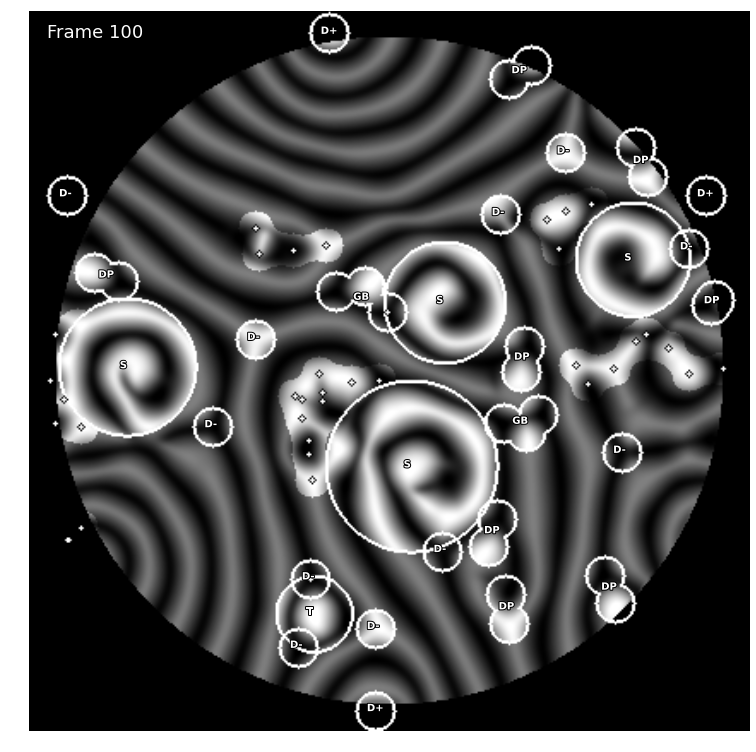

In [122]:
idx = 100

(features, singular_points, pinches, bmp, plumes_loc) = loadData(idx)

# Turn singular_points into an array of singular point values
singular_points = singular_points.astype(np.int)
td_classify = np.zeros(bmp.shape)
td_classify[singular_points['row'], singular_points['col']] = singular_points['type']

# Turn plume_loc into an array of h1 generator indicators
plumes_loc = plumes_loc.astype(np.int)
persistence_h1_gens = np.zeros(bmp.shape)
persistence_h1_gens[plumes_loc['row'], plumes_loc['col']] = 1

# Process defects
radius = 10

# Get the defects
all_defects = classify_all_defects(bmp, td_classify, persistence_h1_gens, radius)

# Combine defects by type
defect_regions = combine_classified_defects_into_regions(bmp, all_defects)

# Aggregate the entire classified region
classified_region = np.zeros(bmp.shape)
for region in defect_regions:
    classified_region = classified_region + defect_regions[region]
    
# Compute the unclassified region and defect-free region
unclassified_defect_region = get_unclassified_defect_region(classified_region, td_classify, radius)
defect_free_region = get_defect_free_region(classified_region, unclassified_defect_region)

# Plot the results
# Crop the temperature field to a circle first.
c = np.zeros((421,421))
centerx = 210
centery = 210
radius=195
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        if ((i-centerx)**2 + (j-centery)**2 < radius**2):
            c[i,j] = 1
c = c.astype(np.int)
print_bmp = bmp
print_bmp[c==0] = 0
plot_defect_classifications(print_bmp, all_defects, unclassified_defect_region, td_classify, defect_free_region);

